In [16]:
!pip install equinox

In [17]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx

## Intro: Jit, ça va vite

In [2]:
key=jax.random.key(0)
w_key, b_key, x_key = jax.random.split(key, 3)

W = jax.random.normal(w_key, (4, 2))
b = jax.random.uniform(b_key, (2,))
x = jax.random.normal(x_key, (4,))

In [3]:
#fonction initiale
def fn_init(W, b, x):
    return x @ W + b

In [4]:
%timeit fn_init(W, b, x).block_until_ready()

In [5]:
#fonction jitée
@jax.jit
def fn_jit(W, b, x):
    return x @ W + b

Premier appel

In [6]:
%time fn_jit(W, b, x).block_until_ready()

Autres appels

In [7]:
%timeit fn_jit(W, b, x).block_until_ready()

Au premier appelle la fonction est "tracée" (=compilée). Cela prend du temps. Ensuite c'est la fonction compilée qui est appelée. C'est très rapide.


Pour bien comprendre comment ça marque, il faut différencier le contenu "statique" et "dynamique" des arguments d'une fonction.

## partie statique et dymanmique des array-like


In [30]:
eqx.is_array(jnp.zeros([3,2]))

In [31]:
eqx.is_array(4)

In [32]:
eqx.is_array_like(4)

Les `array_like` c'est:

*  les `float` qui sont assimilés à des tenseurs de shape `()` et de dtype `float32`

*  les `int` qui sont assimilés à des tenseurs de shape `()` et de dtype `int32`

*  les `bool` qui sont assimilés à des tenseurs de shape `()` et de dtype `bool`




Le contenu statique d'un array-like, c'est sa shape et son dtype. Le contenu dynamique, c'est les valeurs.



Exemples: On utilise le symbole `≈` pour désigner des jit-tenseurs qui on le même contenu statique.


    jnp.zeros([3,2]) ≈ jnp.ones([3,2])
    jnp.zeros([3,3]) ≉ jnp.ones([3,2])

    jnp.array([3.,3,3]) ≈ jnp.array([1.,1,1])
    jnp.array([3.,3,3,3]) ≉ jnp.array([1.,1,1])

    jnp.zeros([3,2]) ≈ np.ones([3,2],dtype=np.float32)
    jnp.zeros([3,2]) ≉ np.ones([3,2]) #par défaut, en numpy, le dtype est float64

    5. ≈ 7. ≈ jnp.array(4.)
    5 ≈ 7 ≈ jnp.array(4)
    5 ≉ 7.

     












### PyTree


Considérons un pytree dont les feuilles sont des array-like. Son contenu statique c'est
1. Sa structure
2. Le contenue statique de chacune de ses feuilles.


Remarque: un simple jit-tenseur est aussi un pytree.



Exemples:

    [jnp.ones([2,2]),jnp.zeros([1,3])] ≈ [jnp.zeros([2,2]),jnp.ones([1,3])]

    {"a":3,"b":jnp.ones([2])} ≈ {"a":7,"b":jnp.zeros([2])}

    (3,None,jnp.ones([3])) ≈  (5,None,jnp.zeros([3]))

Mais:

    (None,3,jnp.ones([3])) ≉  (3,None,jnp.ones([3]))
    {"a":3,"b":jnp.ones([2])} ≉ {"c":3,"b":jnp.ones([2])}


### traçage

tracer = compiler. Il est important de savoir à quel moment JAX va tracer, car cela prend du temps.


Lors du premier appel, la fonction python est exécutée de manière classique, le graphe des calculs est "tracé" et mis en "cache" (en mémoire).

Le cache est un dictionnaire dont les clés sont les hash du contenu statique des arguments rencontrés.

Ainsi, ce cache sera réutilisé si la fonction est appelée une seconde fois avec des arguments qui ont le même contenu statique qu'un précédent appel.


La fonction `print` n'est appelée que lors du traçage. Pratique pour repérer les différents traçages:


In [10]:
@jax.jit
def fn(tens):
    print(f"traçage, tens.shape={tens.shape}, tens.dtype={tens.dtype}")
    return tens

tensors=[
            jnp.zeros([3,2]),jnp.ones([3,2]),
            jnp.zeros([3,3]),jnp.ones([3,3]),
            jnp.zeros([3,2],dtype=int),jnp.ones([3,2],dtype=int),
         ]

for tens in tensors:
    fn(tens)

In [13]:
@jax.jit
def fn(a_bool,tens):
    print(f"traçage, a_bool:{a_bool}, tens.shape={tens.shape}, tens.dtype={tens.dtype}")
    return tens,a_bool

for a_bool in [True,False]:
    fn(a_bool,jnp.zeros([3,2]))

Notez que `a_bool` est n'est pas un vrai array.

### Traçage imbriqué:

Le traçage d'une fonction provoque le traçage des sous-fonction. Mais regardez:

In [36]:
def fn(a_bool,tens):
    print(f"traçage, a_bool:{a_bool}, tens.shape={tens.shape}, tens.dtype={tens.dtype}")
    return tens,a_bool

@jax.jit
def mothed_fn(a_bool,tens):
    print(f"traçage de la mother_fn")
    return fn(a_bool,tens)

for a_bool in [True,False]:
    for tens in [jnp.zeros([3,2]),jnp.ones([3,2])]:
        mothed_fn(a_bool,tens)


Précédemment, `fn` a été tracé une seule fois comme on s'y attend.

In [37]:
def fn(a_bool,tens):
    print(f"traçage, a_bool:{a_bool}, tens.shape={tens.shape}, tens.dtype={tens.dtype}")
    return tens,a_bool

@jax.jit
def mothed_fn():
    print(f"traçage de la mother_fn")
    res=[]
    for a_bool in [True,False]:
        for tens in [jnp.zeros([3,2]),jnp.ones([3,2])]:
            res.append(fn(a_bool,tens))
    return res

mothed_fn();


Et ci-dessus, `fn` est tracé 4 fois !

Cela faut souvent le coup de tracer aussi les sous-fonctions:

In [38]:
@jax.jit
def fn(a_bool,tens):
    print(f"traçage, a_bool:{a_bool}, tens.shape={tens.shape}, tens.dtype={tens.dtype}")
    return tens,a_bool

@jax.jit
def mothed_fn():
    print(f"traçage de la mother_fn")
    res=[]
    for a_bool in [True,False]:
        for tens in [jnp.zeros([3,2]),jnp.ones([3,2])]:
            res.append(fn(a_bool,tens))
    return res

mothed_fn();


### Argument déclaré statique.



Mais dans une signature on peut déclarer des arguments comme statiques (= entièrement statique). Dans ce cas là, la valeur précise de cet argument fait partie de son contenu statique.








In [40]:
from functools import partial
import jax.random as jr

@partial(jax.jit,static_argnames="y")
def identity2(x,y):
    print(f"traçage avec x.dtype={x.dtype}, x.shape={x.shape} et y={y}")
    return x

rkey=jr.key(0)
for y in range(5):
    rkey,subkey=jr.split(rkey)
    identity2(jr.normal(subkey,(3,2)),y)

In [41]:
for y in range(5):
    rkey,subkey=jr.split(rkey)
    identity2(jr.normal(subkey,(3,2)),y)

⇑ Les 5 variantes avaient déjà été tracées.

ATTENTION

* Un argument statique doit être hashable (car il doit servir à construire la clés qui décrit le traçage de la fonction dans le cash).

* Tous les arguments qui ne sont pas des pytree dont les feuille sont des array-like doivent nécessairement être déclarées comme statique.


Notons que les simples fonctions sont hashables:

In [42]:
def fn(a):
    return a
hash(fn)

In [43]:
@partial(jax.jit,static_argnames="fn")
def integrate(a,b,fn):
    print("traçage")
    x=jnp.linspace(a,b,100)
    return jnp.sum(fn(x))/(b-a)

for a,b in [(0,1),(0,2)]:
    for fn in [jnp.sin,jnp.cos]:
        integrate(a,b,fn)

### La technique equinox

Equinox considère que toutes les variables qui ne sont pas des tenseurs sont statiques. Et l'emploie de `@eqx.filter_jit` évite d'avoir à préciser quels sont les arguments statiques


In [44]:
@eqx.filter_jit
def integrate(a,b,fn):
    print("traçage")
    x=jnp.linspace(a,b,100)
    return jnp.sum(fn(x))/(b-a)

for a,b in [(0,1),(0,2)]:
    for fn in [jnp.sin,jnp.cos]:
        integrate(a,b,fn)

In [46]:
@eqx.filter_jit
def integrate(a,b,fn):
    print("traçage")
    x=jnp.linspace(a,b,100)
    return jnp.sum(fn(x))/(b-a)

#La première boucle uilise de vrais arrays
for a,b in [jnp.array([0,1]),jnp.array([0,2])]:
    for fn in [jnp.sin,jnp.cos]:
        integrate(a,b,fn)

## Les contraintes

### Sur la structure

La structure d'une fonction jité ne doit dépendre que du contenu statique de ses arguments.

In [ ]:
@jax.jit
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

try:
    f(10)
except Exception as e:
    print(e)

In [ ]:
@jax.jit
def f(x):
    print("traçage")
    if x.ndim==2:
        return x
    else:
        return 2 * x

f(1)

In [ ]:
f(jnp.ones([2,2]))

In [ ]:
@jax.jit
def f(x,stop):
    print("traçage")
    for _ in range(stop):
        x=x*x
    return x

try:
    f(10,2)
except Exception as e:
    print(e)

In [ ]:
@partial(jax.jit,static_argnames="stop")
def f(x,stop):
    print("traçage")
    for _ in range(stop):
        x=x*x
    return x

f(10,2)

In [ ]:
f(1,2)

In [ ]:
f(1,3)

### Les shape et les dtype interne


Toutes les shape et dtype des tenseurs à l'intérieux d'une fonction jitée de doivent dépendre que du contenu statique des arguments.

In [ ]:
@jax.jit
def f(x):
    mask= x>0
    x=x.at[mask].set(-100)
    return x


try:
    f(jnp.array([1,-1]))
except Exception as e:
    print(e)

#### ♡♡♡♡

***A vous:*** Réécrivez la fonction précédente, à l'aide de `jnp.where` pour qu'elle puisse être jitée.

In [ ]:
@jax.jit
def f(value,shape):
    return jnp.ones(shape)*value

try:
    f(3.,(2,2))
except Exception as e:
    print(e)

In [ ]:
@partial(jax.jit,static_argnames="shape")
def f(value,shape):
    return jnp.ones(shape)*value

f(3.,(2,2))

## Optimisations



### Observons le code `jaxpr` et le code `XLA`


Lors du premier appel, la fonction python est exécutée "ligne à ligne" (de manière classique), le graphe des calculs est alors "tracé" en un language appelé `jaxpr`.

Cette représentation intermédiaire est ensuite donnée à XLA qui l'écrit dans son propre language, en cherchant des optimisations.

In [ ]:
@jax.jit
def log2(x):
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.)
    return ln_x / ln_2

jax.make_jaxpr(log2)(jnp.array([2.,3,4]))

#### ♡♡♡


In [ ]:
print(log2.lower(jnp.array([2.,3,4])).compile().as_text())

### On ne garde que les branches de `if` nécessaires.

Remarquons que seule les parties du code parcourues sont transformée en `jaxpr`

In [ ]:
def log2_if_rank_2(x):
    if x.ndim ==2 :
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.)
        return ln_x / ln_2
    else:
        return x


jax.make_jaxpr(log2_if_rank_2)(jnp.array(2.))

In [ ]:
jax.make_jaxpr(log2_if_rank_2)(jnp.zeros([2,2]))

### On déroulle les boucles

 `jaspr` et `XLA` déroulent (unroll) les boucles.

In [ ]:
@jax.jit
def fn_with_loop(x):
    for _ in range(10):
        x = x * x
    return x

x=jnp.array(2)
jax.make_jaxpr(fn_with_loop)(x)

In [ ]:
print(fn_with_loop.lower(x).compile().as_text())

### XLA supprime des parties inutiles

***A vous:*** Qu'est-ce qui est stupide la fonction ci-dessous:

In [ ]:
@jax.jit
def fn_with_stupid_loop(x):
    y  = x
    for _ in range(10):
        y = y*y
    return x

x=jnp.array(2)
jax.make_jaxpr(fn_with_stupid_loop)(x)

Voici maintenant le code compilé par XLA

In [ ]:
print(fn_with_stupid_loop.lower(x).compile().as_text())

`XLA` a repéré que la boucle était inutile.

### Le inplace devient inplace

In [ ]:
@jax.jit
def inplace_update(x):
    x=x.at[:,0].set(5)
    x=x.at[:,1].set(10)
    return x

x=jnp.zeros([10,2])
inplace_update(x)

Le tenseur `x` en entrée est copiée une fois, puis les opérations déclarée avec `at` sont faites inplace pour économiser de la mémoire.

Idem si l'on fait `x = x + 5`. Si le contue mémoire de `x` n'est pas utilisé ailleurs, alors l'opération devient in-place.

## Argument globaux

### globaux comme entrée


Les arguments globaux (= ceux qui ne passent pas par la signature)  traité comme des arguments statiques et copiés (copie profonde) au moment du traçage.

C'est dangereux. Exemple:

In [ ]:
shift = -1.0


@jax.jit
def fn(x):
  return x + shift

In [ ]:
print(fn(jnp.array([0, 1, 2])))
print(fn(jnp.array([0, 10, 20])))

In [ ]:
shift = 0

In [ ]:
print(fn(jnp.array([0, 1, 2])))
print(fn(jnp.array([0, 10, 20])))

In [ ]:
print(fn(jnp.array([0., 1, 2])))
print(fn(jnp.array([0., 10, 20])))

#### ♡♡♡

***A vous:*** Expliquez ce qui c'est passé.

### Glogaux comme sortie

In [ ]:
dico_glob={"value":0}

def modifie_dico():
    dico_glob["value"]+=1

modifie_dico()
print(dico_glob)

In [ ]:
modifie_dico()
print(dico_glob)

In [ ]:
modifie_dico=jax.jit(modifie_dico)

In [ ]:
modifie_dico()
print(dico_glob)

In [ ]:
modifie_dico()
print(dico_glob)

#### ♡♡♡

***A vous:*** Expliquez ce qui c'est passé.

###  La pattern `jit_creator`

Perso j'utilise souvent cette pattern de programmation qui me semble simple, et peu dangeureuse:

In [ ]:
def jit_creator(model_call):

    @jax.jit
    def loss_compute(model_param, X,Y):
        Y_pred=model_call(model_param,X)
        return jnp.mean((Y_pred-Y)**2)


    return loss_compute

#Plus loin dans le code, quand on aura définit model_call, on pourra calcuer la loss.

qui est l'équivalent de:

In [ ]:
@partial(jax.jit, static_argnames=['model_call'])
def loss_compute2(model_param, X,Y,model_call):
        Y_pred=model_call(model_param,X)
        return jnp.mean((Y_pred-Y)**2)

Testons

In [ ]:
def model_call(param,X):
    return param@X

param=jnp.ones([1,5])
X=jnp.ones([5,2])
Y=jnp.ones([1,2])

Avec ma technique:

In [ ]:
loss_compute1=jit_creator(model_call)

loss_compute1(param,X,Y)


Avec l'argument statique:

In [ ]:
loss_compute2(param,X,Y,model_call)

## Le conseil "Equinox"


### Se simplifier la vie



Pour se simplifier la vie:


Comme argument dynamique n'utilisez que des tenseurs jax, ainsi que des pytree dont les feuilles sont des tenseurs jax ou des None.

Déclarer tout le reste comme argument statique.


C'est cette partern qu'on utilisera pour faire des réseaux de neurones avec `Equinox`.


Avec cette technique, quasi-tout est statique sauf: les valeurs dans les tenseurs jax.  


On a l'impression que cela fait beaucoup trop de "retraçage". Mais en fait pas tant que ça pour un programme de deep-learning. Dans l'article original de JAX ils écrivent:


> The design of JAX is informed by the observation that ML workloads are typically dominated by PSC (pure-and-statically-composed) subroutines


Ce n'est pas faux, si l'on prend quelques précautions. Par exemple,

* On évitera de faire varier la taille des batchs pendant la boucle d'entrainement.

* Pour les modèles de languages, il faut inclure les phrases avec un padding constant.

* On n'incluera pas la boucle principale d'apprentissage dans une fonction `jax`. Mais plutôt les `train_step` et `val_step`.


### Cela évite ceci

In [ ]:
@jax.jit
def bad_performant(x):
    return jnp.sum(jnp.stack(x))

bad_performant([i for i in range(100)])

#### ♡♡♡♡

Ecrivez le code `jaxpr` de la fonction précédente. Expliquez pourquoi c'est un code peu performant (et pas uniquement à cause du manque de vectorisation).

## Conditions et boucles dynamiques

### `lax.cond`

Cette fonction est l'équivalent de:

In [ ]:
def cond(predicat, true_fun, false_fun, operand):
  if predicat:
    return true_fun(operand)
  else:
    return false_fun(operand)

In [ ]:
from jax import lax

operand = jnp.array([0.])
lax.cond(True, lambda x: x+1, lambda x: x-1, operand)

In [ ]:
lax.cond(False, lambda x: x+1, lambda x: x-1, operand)

Et dans une fonction jitée, `lax.cond` peut être utilisé avec un prédicat dynamique:

In [ ]:
@jax.jit
def use_cond(operand,a):
    predicat= (a==77)
    return lax.cond(predicat, lambda x: x+1, lambda x: x-1, operand)

use_cond(jnp.array([0.]),jnp.array(77))

In [ ]:
use_cond(jnp.array([0.]),jnp.array(78))

`lax.while`

C'est l'équivalent de:

In [ ]:
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val

In [ ]:
init_val = 0
cond_fun = lambda x: x < 10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)

### `lax.fori_loop`

C'est l'équivalent de:

In [ ]:
def fori_loop(start, stop, body_fun, init_val):
  val = init_val
  for i in range(start, stop):
    val = body_fun(i, val)
  return val

In [ ]:
@jax.jit
def use_fori_loop(init_val,stop):
    body_fun = lambda i,x: x+i
    return lax.fori_loop(0, stop, body_fun, init_val)

use_fori_loop(0.,10)

Remarquons que la boucle n'est pas déroulée.

In [ ]:
jax.make_jaxpr(use_fori_loop)(0.,10)

Idem en rendant l'argument `stop` statique: la fonction sera donc retracée à chaque changement de valeur pour stop: Avantage: la fonction sera alors "rev-mode-differentiable". Tandis qu'avec des bornes dynamique elle n'est que "fwd-mode-differentiable"

In [ ]:
@partial(jax.jit,static_argnames="stop")
def use_fori_loop(init_val,stop):
    body_fun = lambda i,x: x+i
    return lax.fori_loop(0, stop, body_fun, init_val)

use_fori_loop(0.,10)

### `lax.scan`

C'est l'équivalent de:

In [ ]:
def scan(f, init, xs):
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)
        ys.append(y)
    return carry, np.stack(ys)

C'est une fonction très utile pour implémenter les `RNN`.

* `xs` représente la série temporelle à traiter.
* `ys` la série temporelle en sortie
* `carry` l'état qui évolue au fur et à mersure du traitement.


Remarque: L'argument `length` n'est utile que si `xs` est `None`

### Bilan des 4 fonctions vues:

Copions l'aide


* `lax.cond` differentiable

* `lax.while_loop` fwd-mode-differentiable

* `lax.fori_loop` fwd-mode-differentiable in general; fwd and rev-mode differentiable if endpoints are static.

* `lax.scan` differentiable

### Autre fonctions de controle

`jax.lax` provides two other functions that allow branching on dynamic predicates:

`lax.select` is like a batched version of  `lax.cond`, with the choices expressed as pre-computed arrays rather than as functions.

`lax.switch` is like `lax.cond`, but allows switching between any number of callable choices.

In addition, `jax.numpy` provides several numpy-style interfaces to these functions:

`jnp.where` with three arguments is the numpy-style wrapper of lax.select.

`jnp.piecewise` is a numpy-style wrapper of `lax.switch`, but switches on a list of boolean conditions rather than a single scalar index.


`jnp.select` has an API similar to `jnp.piecewise`, but the choices are given as pre-computed arrays rather than as functions. It is implemented in terms of multiple calls to `lax.select`.

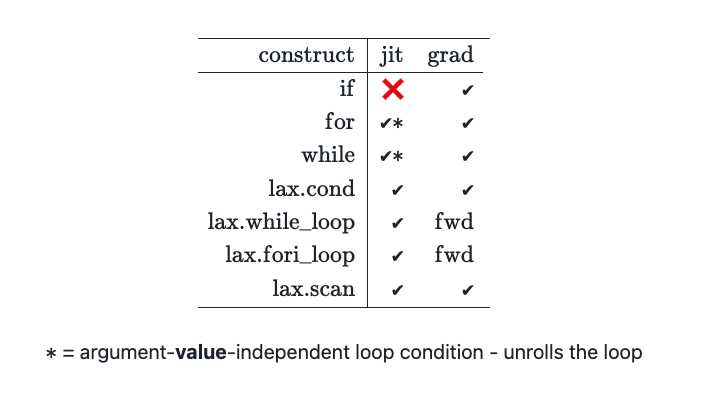

### Opérateurs logiques

`jax.numpy` provides `logical_and, logical_or, and logical_not`, which operate element-wise on arrays and can be evaluated under jit without recompiling. Like their Numpy counterparts, the binary operators do not short circuit. Bitwise operators (&, |, ~) can also be used with jit.







In [ ]:
def python_check_positive_even(x):
  is_even = (x % 2 == 0)
  # `and` short-circults, so when `is_even` is `False`, `x > 0` is not evaluated.
  return is_even and (x > 0)

@jax.jit
def jax_check_positive_even(x):
  is_even = (x % 2 == 0)
  # `logical_and` does not short circuit, so `x > 0` is always evaluated.
  return jnp.logical_and(is_even, x > 0)

print(python_check_positive_even(24))
print(jax_check_positive_even(24))